<img src="https://global.utsa.edu/tec-partnership/images/logos/logotipo-horizontal-azul-transparente.png"  width="600">

## **Actividad 4 | Métricas de calidad de resultados**
### **Análisis de grandes volúmenes de datos (Gpo 10)**
#### Tecnológico de Monterrey
---
*   NOMBRE: Paulina Escalante Campbell
*   MATRÍCULA: A01191962
---
### **Objetivo**
Identificar métricas para la medición de la calidad de resultados derivados de la aplicación de modelos de aprendizaje, ya sea supervisado o no supervisado, orientado al procesamiento de grandes volúmenes de datos, que permitan la selección de los modelos que mejor se ajusten a la tarea de aprendizaje a resolver.

#### **Imports**


In [73]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

import findspark
findspark.init()
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, sum, when, split, col, lit, max, min, expr
from pyspark.sql.functions import to_date, var_samp, variance, var_pop, month, to_timestamp, dayofweek
from pyspark.sql.functions import hour, month
from pyspark.sql.types import NumericType, IntegerType, FloatType
from pyspark.sql.functions import col, round, concat_ws, desc, when, concat
from pyspark.sql import functions as F

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

from datetime import datetime

# Imports adicionales necesarios
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when, count as spark_count
import numpy as np

### **1. Construcción de la muestra M**

Construir una muestra M que sea representativa de la población P (a partir del dataset que recolectaste desde el inicio del curso). Tomando como base el conocimiento adquirido en la Actividad 3 del Módulo 4, generarás particiones Mi de M, donde cada Mi cumple con los criterios definidos por las variables de caracterización que identificaste previamente (M será igual a la unión de todos los Mi). Para esta actividad, y a diferencia del paso previo, se deberá de tener especial cuidado para determinar el número de instancias que deberá contender cada partición Mi a generar, de tal forma que no se inyecte ningún tipo de sesgo que pueda alterar la calidad de los resultados.

In [2]:
spark = SparkSession.builder \
    .appName("Maestria_evidencia1") \
    .config("spark.driver.memory", "64g") \
    .config("spark.executor.memory", "32g") \
    .config("spark.sql.shuffle.partitions", "32") \
    .config("spark.default.parallelism", "16") \
    .config("spark.driver.maxResultSize", "16g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Mejores tablas
#spark, comentando el comando del environment para reducir el ruido del notebook

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/08 21:17:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [45]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

####
#### La base de datos ha sido limpiada y modificada a este punto
#### 
####
file_path = "/Users/pauescalante/Documents/Maestria/Trimestre 7/BigData/big-data-act/DataModified/expanded_database_ecommerce"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Mostrar cuantos registros se tienen inicialmete para en el futuro reducir a una dimensión contenida
initial_total_count = df.count()
print(f"Número total de registros: {initial_total_count}")

[Stage 159:================================================>   (135 + 11) / 146]

Número total de registros: 109950731


In [46]:
# Imprimiendo el esquema del Dataframe
df.printSchema()

root
 |-- event_time: date (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- event_time_ts: timestamp (nullable = true)
 |-- parent_category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- price_bucket: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- is_weekend: boolean (nullable = true)



In [47]:
# Mostrar el primer registro de ejemplo para visualizar las columnas
df.show(n=1,truncate=False, vertical=True)

-RECORD 0-----------------------------------------------
 event_time      | 2019-11-17                           
 event_type      | view                                 
 product_id      | 5300440                              
 category_id     | 2053013563173241677                  
 brand           | vitek                                
 price           | 17.76                                
 user_id         | 513341639                            
 user_session    | d9544029-2739-4d16-9cac-79650460d9f0 
 event_time_ts   | 2019-11-17 05:35:32                  
 parent_category | None                                 
 subcategory     | None                                 
 price_bucket    | low                                  
 day_of_week     | 1                                    
 is_weekend      | true                                 
only showing top 1 row



In [48]:
# En este punto en actividades previas se limpiaron los datos
# Pero haremos una última limpieza para verificar

#Se eliminan registros con valores nulos
df_clean = df.dropna()

#Se eliminan columnas con valores nulos
df_clean = df_clean.na.drop()

#Se eliminan registros duplicados
df_clean = df_clean.dropDuplicates()

In [49]:
# Calcular muestras M pre-procesada, en la actividad anterior definimos que SRS (Simple Random Sampling) era buena opción
# Ya que tenemos una poblacion muy grande (approx. 109950731, podemos usar un 0.01% de muestra y tener un número significativo de datos)
print("\n--- SRS sampling: ---")
sample_df = df.sample(fraction=0.0001)
total_count_sample = sample_df.count()
print(f"New sample size: {total_count_sample})")

# Variables de Caracterización Seleccionadas
#event_type: Representa el funnel de conversión (view → cart → purchase)
#price_bucket: Segmenta productos por rango de precio (low/medium/high)


--- SRS sampling: ---


[Stage 163:=================================================>   (137 + 9) / 146]

New sample size: 10773)


In [50]:
# Se añade una nueva columna que combina los valores de los atributos event_type y event_type
# Las variables de caracterización serán usadas para un multistep muestro para representar la población
from pyspark.sql.functions import concat, lit
preparedDF_a_srs = sample_df.withColumn("stratum", concat(sample_df["event_type"], lit("_"), sample_df["price_bucket"]))
preparedDF_a_srs.show(n=1,truncate=False, vertical=True)

-RECORD 0-----------------------------------------------
 event_time      | 2019-11-17                           
 event_type      | view                                 
 product_id      | 1004838                              
 category_id     | 2053013555631882655                  
 brand           | oppo                                 
 price           | 154.42                               
 user_id         | 544940181                            
 user_session    | c6b07b4d-6e11-4207-914b-37ab0e693b42 
 event_time_ts   | 2019-11-17 05:37:42                  
 parent_category | electronics                          
 subcategory     | smartphone                           
 price_bucket    | medium                               
 day_of_week     | 1                                    
 is_weekend      | true                                 
 stratum         | view_medium                          
only showing top 1 row



In [51]:
# Se calcula la cantidad de instancias por cada valor diferente de las variables event_type, price_bucket y combinada
srs_counts_event_type = preparedDF_a_srs.groupBy("event_type").count().collect()
srs_counts_price_bucket = preparedDF_a_srs.groupBy("price_bucket").count().collect()
srs_counts_combined_a = preparedDF_a_srs.groupBy("event_type", "price_bucket").count().collect()
srs_counts_combined = preparedDF_a_srs.groupBy("stratum").count().collect()

print(srs_counts_event_type)
print("\n")
print(srs_counts_price_bucket)
print("\n")
print(srs_counts_combined_a)
print("\n")
print(srs_counts_combined)

[Stage 176:====================================================>(144 + 2) / 146]

[Row(event_type='purchase', count=166), Row(event_type='view', count=10229), Row(event_type='cart', count=378)]


[Row(price_bucket='low', count=3679), Row(price_bucket='high', count=3239), Row(price_bucket='medium', count=3855)]


[Row(event_type='cart', price_bucket='high', count=133), Row(event_type='view', price_bucket='medium', count=3632), Row(event_type='view', price_bucket='low', count=3535), Row(event_type='cart', price_bucket='medium', count=150), Row(event_type='purchase', price_bucket='medium', count=73), Row(event_type='purchase', price_bucket='low', count=49), Row(event_type='view', price_bucket='high', count=3062), Row(event_type='cart', price_bucket='low', count=95), Row(event_type='purchase', price_bucket='high', count=44)]


[Row(stratum='cart_low', count=95), Row(stratum='cart_high', count=133), Row(stratum='view_low', count=3535), Row(stratum='purchase_medium', count=73), Row(stratum='purchase_low', count=49), Row(stratum='view_high', count=3062), Row(stratum='view_

In [58]:
# 2. Obtener los conteos por estrato
strata_counts = preparedDF_a_srs.groupBy("stratum").count().collect()
total_count = preparedDF_a_srs.count()  # 10,000

# 3. Calcular las fracciones manteniendo las proporciones
fractions = {}
for row in strata_counts:
    stratum = row["stratum"]
    count = row["count"]
    
    # Proporción de este estrato en la población total
    proportion = count / total_count
    
    # Tamaño objetivo para este estrato
    target_stratum_size = target_sample_size * proportion
    
    # Fracción de muestreo (no puede ser mayor a 1.0)
    sampling_fraction = target_stratum_size / count
    fractions[stratum] = sampling_fraction if sampling_fraction <= 1.0 else 1.0

print("Fracciones de muestreo por estrato:")
for stratum, fraction in fractions.items():
    print(f"{stratum}: {fraction:.4f}")

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
[Stage 212:===============================================>    (134 + 12) / 146]

Fracciones de muestreo por estrato:
cart_low: 0.4641
cart_high: 0.4641
view_low: 0.4641
purchase_medium: 0.4641
purchase_low: 0.4641
view_high: 0.4641
view_medium: 0.4641
cart_medium: 0.4641
purchase_high: 0.4641


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [59]:
# Se generan los conjuntos a partir de muestreo estratificado
df_multistep_srs_stratum = preparedDF_a_srs.sampleBy("stratum", fractions=fractions, seed=42)

print(f"""Existen {df_multistep_srs_stratum.count()} instancias en el conjunto""")
df_multistep_srs_stratum.show(n=1, truncate=False, vertical=True)

Existen 5011 instancias en el conjunto
-RECORD 0-----------------------------------------------
 event_time      | 2019-11-17                           
 event_type      | view                                 
 product_id      | 1004982                              
 category_id     | 2053013555631882655                  
 brand           | samsung                              
 price           | 1029.34                              
 user_id         | 515122138                            
 user_session    | afb4820f-664e-4e7e-b242-0de69ad979f9 
 event_time_ts   | 2019-11-17 05:42:31                  
 parent_category | electronics                          
 subcategory     | smartphone                           
 price_bucket    | high                                 
 day_of_week     | 1                                    
 is_weekend      | true                                 
 stratum         | view_high                            
only showing top 1 row



In [61]:
# sample_df tiene la muestra de la población del data set original
# Ahora usamos el stratified set
sample_df_verify = df_multistep_srs_stratum
total_count_sample = sample_df_verify.count()
print(f"New sample size: {total_count_sample})")

[Stage 222:====================================================>(144 + 2) / 146]

New sample size: 5011)


In [62]:
# Calcular distribuciónes nuevamente del sample
sample_price_bucket_distribution = (
    sample_df_verify.groupBy("price_bucket")
    .count()
    .withColumn("total", lit(total_count_sample))
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2))
    .select("price_bucket", "count", "percentage")
    .orderBy("price_bucket")
)

sample_event_type_distribution = (
    sample_df_verify.groupBy("event_type")
    .count()
    .withColumn("total", lit(total_count_sample))
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2))
    .select("event_type", "count", "percentage")
    .orderBy("event_type")
)

# Se puede observar que el sample tiene distribuciónes similares a la poblacion
# Los nuevos valores son sample_df y total_count_sample de ahora en adelante
print("\n--- Distribución del sample price_bucket: ---")
sample_price_bucket_distribution.show()

print("\n--- Distribución del sample event_type: ---")
sample_event_type_distribution.show()


--- Distribución del sample price_bucket: ---


+------------+-----+----------+
|price_bucket|count|percentage|
+------------+-----+----------+
|        high| 1519|     30.31|
|         low| 1684|     33.61|
|      medium| 1808|     36.08|
+------------+-----+----------+


--- Distribución del sample event_type: ---


[Stage 228:==================================================>  (140 + 6) / 146]

+----------+-----+----------+
|event_type|count|percentage|
+----------+-----+----------+
|      cart|  197|      3.93|
|  purchase|   79|      1.58|
|      view| 4735|     94.49|
+----------+-----+----------+



### **2. Construcción Train – Test**

Construcción del conjunto de entrenamiento y prueba. Para este paso se asume que M = {Mi: Mi es una partición derivada de las variables de caracterización de la población} generada en el paso anterior. Para construir el conjunto de entrenamiento y prueba, se debe de calcular el porcentaje de división a usar, de tal forma que al dividir cada Mi en un conjunto de entrenamiento (Tri) y prueba (Tsi), no se inyecten sesgos que desvíen la probabilidad de ocurrencia de los patrones en cada nueva partición. Para ello, deberás de retomar la estrategia de muestreo propuesta en el paso 4 de la Actividad 3 del módulo 4. Se debe de cuidar que Tri Ç Tsi = Æ, además de que la unión de todas las particiones es igual a M.

In [63]:
sample_df = sample_df_verify
# Para separar la muestra entre sets de entrenamiento y prueba se usa un 80:20
# Es el estándar en ML y un buen balance
print("\n-- Entrenamiento/Prueba ---")
train_ratio = 0.8
test_ratio = 0.2
random_seed = 42

# Establece el número de particiones que se usarán al hacer operaciones como shuffle (por ejemplo, en joins, agregaciones o splits).
# Un número mayor puede mejorar la distribución de los datos en clústeres grandes, pero también aumentar el uso de recursos.
spark.conf.set("spark.sql.shuffle.partitions", "200") # puede alterar los resultados, empezamos con un número mayor

# Divide aleatoriamente el DataFrame `sample_df` en dos subconjuntos: uno para entrenamiento y otro para prueba.
train_data,test_data = sample_df.randomSplit([train_ratio,test_ratio], seed = random_seed)

# Imprime cuántas instancias hay en el conjunto de entrenamiento y cuántas en el conjunto de prueba.
print(f"""Existen {train_data.count()} instancias en el conjunto train, y {test_data.count()} en el conjunto test""")


-- Entrenamiento/Prueba ---


[Stage 234:====================================================>(144 + 2) / 146]

Existen 4000 instancias en el conjunto train, y 1011 en el conjunto test


In [64]:
# Verificar proporciones de los sets de training y de test con event_type, ya que esta columna tiene una distribución esperada
train_dist = train_data.groupBy("event_type").count().withColumnRenamed("count", "train_count")
test_dist = test_data.groupBy("event_type").count().withColumnRenamed("count", "test_count")
verification = train_dist.join(test_dist, "event_type")

# Las distribuciones son esperadas, con view > cart > purchase0
print("\n--- Verificación de proporciones event_type: ---")
verification.show()


--- Verificación de proporciones event_type: ---


[Stage 238:===================================================> (142 + 4) / 146]

+----------+-----------+----------+
|event_type|train_count|test_count|
+----------+-----------+----------+
|      view|       3780|       955|
|      cart|        155|        42|
|  purchase|         65|        14|
+----------+-----------+----------+



In [65]:
# Verificar proporciones de los sets de training y de test con event_type, ya que esta columna tiene una distribución normal
train_dist_2 = train_data.groupBy("price_bucket").count().withColumnRenamed("count", "train_count")
test_dist_2 = test_data.groupBy("price_bucket").count().withColumnRenamed("count", "test_count")
verification_2 = train_dist_2.join(test_dist_2, "price_bucket")

# Las distribuciones son esperadas, con un 33% aproximado en cada categoría 
print("\n--- Verificación de proporciones price_bucket: ---")
verification_2.show()


--- Verificación de proporciones price_bucket: ---


[Stage 244:===================================================> (142 + 4) / 146]

+------------+-----------+----------+
|price_bucket|train_count|test_count|
+------------+-----------+----------+
|         low|       1340|       344|
|        high|       1202|       317|
|      medium|       1458|       350|
+------------+-----------+----------+



### **3. Selección de métricas para medir calidad de resultados**

Con la finalidad de medir la calidad de resultados que se obtienen, se debe de seleccionar previamente métricas para su medición. Se recomienda que se analice a profundidad que métricas se pueden aplicar, considerando que se trabaja con grandes volúmenes de datos.

Dado que nuestro dataset presenta un alto desbalance de clases con únicamente 1.5% de casos positivos (compras), la selección de métricas de evaluación debe considerar cuidadosamente las limitaciones que esto conlleva. La métrica de **accuracy** (exactitud), aunque es ampliamente utilizada en problemas de clasificación binaria, resulta inadecuada para este contexto ya que un modelo trivial que prediga siempre "no compra" obtendría una exactitud del 98.5%, enmascarando su incapacidad total para identificar las compras reales.

Por esta razón, implementaremos un conjunto complementario de métricas usando **BinaryClassificationEvaluator** de Spark MLlib. El **Area Under ROC Curve (AUC-ROC)** será nuestra métrica principal, ya que evalúa la capacidad del modelo para discriminar entre clases independientemente del umbral de decisión y es menos sensible al desbalance que accuracy. Adicionalmente, utilizaremos **precision** (precisión) para medir qué porcentaje de las predicciones positivas son correctas, minimizando falsos positivos que impactarían negativamente las campañas de marketing dirigidas. El **recall** (sensibilidad) será crucial para capturar la mayor cantidad posible de compradores potenciales, evitando la pérdida de oportunidades de venta.

La métrica **F1-score** proporcionará un balance entre precision y recall, especialmente valiosa cuando necesitamos optimizar ambos aspectos simultáneamente. Para datasets desbalanceados como el nuestro, también consideraremos el Area Under Precision-Recall Curve (AUC-PRC), que ofrece una perspectiva más informativa que AUC-ROC cuando la clase positiva es minoritaria. Finalmente, implementaremos una matriz de confusión para analizar detalladamente los tipos de errores y calcular métricas específicas como la especificidad, permitiendo una evaluación integral del comportamiento del modelo en ambas clases y facilitando la toma de decisiones sobre umbrales óptimos de clasificación según el contexto de negocio.

### **4. Entrenamiento de Modelos de Aprendizaje**

Construcción de modelos de aprendizaje. Para esta etapa y partiendo de la elección de algoritmos de aprendizaje (supervisado, no supervisado), aplicarás un proceso de entrenamiento que te permita construir modelos de aprendizaje que ayude a identificar los patrones de interés existentes en los datos. Se deberá de tener en claro la estrategia de entrenamiento a implementar, desde la forma en la cual se procesarán los datos hasta el ajuste de hiper – parámetros a emplear, además de los ajustes y técnicas adicionales que impidan que los modelos generados estén sobre- ajustados.

#### 5.1 Aprendizaje Supervisado

Para el problema de aprendizaje supervisado haremos un análisis binario de predicción: compra o no compra

- Variable objetivo: label (1 = purchase, 0 = no purchase)
- Desafío: Dataset altamente desbalanceado (1.5% positivos)

In [66]:
# Preparar la variable objetivo "label" que identifica si es compra o no
supervised_df = train_data.withColumn("label", 
                                   when(col("event_type") == "purchase", 1.0)
                                   .otherwise(0.0))

print("Variable objetivo: label (1=purchase, 0=no purchase)")

# Seleccionar características, en este caso tenemos variables numéricas y categóricas
feature_cols = ["price", "day_of_week"]
categorical_cols = ["brand", "parent_category", "price_bucket"]

print(f"Características numéricas: {feature_cols}")
print(f"Características categóricas: {categorical_cols}")

# Revisar resultado
sample_df.select("event_time", "day_of_week").show(5)

Variable objetivo: label (1=purchase, 0=no purchase)
Características numéricas: ['price', 'day_of_week']
Características categóricas: ['brand', 'parent_category', 'price_bucket']
+----------+-----------+
|event_time|day_of_week|
+----------+-----------+
|2019-11-17|          1|
|2019-11-17|          1|
|2019-11-17|          1|
|2019-11-17|          1|
|2019-11-17|          1|
+----------+-----------+
only showing top 5 rows



In [67]:
# Preparación del dataframe para ser procesado con algoritmos de ML en PySpark
# Se usa VectorAssembler para generar una o más columnas en la cual, se "encapsulan" en un vector único
# los valores de los descriptores a usar en el proceso de aprendizaje.

# Indexar las variables categóricas (String → Numérico).
# Se crea una lista de transformadores StringIndexer, uno por cada columna categórica.
# `handleInvalid="skip"` evita errores si hay valores nulos o inesperados.
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="skip") 
            for col in categorical_cols]

# Ensamblar todas las variables numéricas y categóricas indexadas en una sola columna de características.
# Esto es necesario porque PySpark ML requiere una sola columna de entrada (`features`) de tipo vector.
feature_cols_final = feature_cols + [f"{col}_indexed" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols_final, outputCol="features")

# Escalar las características para normalizar los valores.
# Esto mejora el rendimiento de muchos algoritmos de ML
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [68]:
# MODELO 1: Regresión Logística
# Baseline estándar para clasificación binaria
print("\n--- Modelo 1: Regresión Logística ---")

# Se especifican las columnas de entrada (`scaledFeatures`) y etiqueta (`label`), y el número máximo de iteraciones.
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="label", maxIter=10)

# Se construye un pipeline que incluye:
# 1. Indexado de columnas categóricas
# 2. Ensamblado de características
# 3. Escalado de variables
# 4. El modelo de regresión logística
lr_pipeline = Pipeline(stages=indexers + [assembler, scaler, lr])

print("Entrenando Regresión Logística...")

# Se entrena el pipeline completo con el DataFrame `supervised_df`.
lr_model = lr_pipeline.fit(supervised_df)
print("Modelo entrenado...")


--- Modelo 1: Regresión Logística ---
Entrenando Regresión Logística...


25/06/08 22:27:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/06/08 22:27:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

Modelo entrenado...


In [69]:
# Se Imprimen los valores de los coeficientes
lr_stage = lr_model.stages[-1]  # Última etapa es LogisticRegression
print("The coefficient of the model is :", lr_stage.coefficients)
print("The intercept of the model is :", lr_stage.intercept)

The coefficient of the model is : [-0.15831008835593044,-0.036537781631237616,-0.41141013085275546,-0.477641022535829,-0.12300920482648102]
The intercept of the model is : -3.3491732075074663


In [70]:
print("\n--- Evaluación de modelos ---")
# Preparar datos de prueba con la variable label
test_supervised = test_data.withColumn("label", 
                                    when(col("event_type") == "purchase", 1.0)
                                    .otherwise(0.0))

# Generar predicciones con el modelo de regresión logística previamente entrenado.
lr_predictions = lr_model.transform(test_supervised)

# Crear un evaluador para clasificación binaria.
# Se usará el área bajo la curva ROC (AUC) como métrica principal para evaluar qué tan bien distingue entre 0 y 1.
binary_evaluator = BinaryClassificationEvaluator(labelCol="label",rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Crear un evaluador adicional para calcular la precisión general (accuracy).
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", 
                                                      predictionCol="prediction", 
                                                      metricName="accuracy")

# Métricas para evaluar
lr_auc = binary_evaluator.evaluate(lr_predictions)
lr_accuracy = accuracy_evaluator.evaluate(lr_predictions)

print(f"\nResultados:")
print(f"Regresión Logística - AUC: {lr_auc:.4f}, Accuracy: {lr_accuracy:.4f}")


--- Evaluación de modelos ---


[Stage 299:====================================================>(144 + 2) / 146]


Resultados:
Regresión Logística - AUC: 0.6971, Accuracy: 0.9861


In [71]:
# Matriz de confusión
print("\nMatriz de confusión:")
confusion_matrix = lr_predictions.groupBy("label", "prediction").count()
confusion_matrix.show()


Matriz de confusión:


[Stage 301:====================================================>(144 + 2) / 146]

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  921|
|  1.0|       0.0|   13|
+-----+----------+-----+



In [74]:
# Agregando a los resultados de la actividad pasada podemoste usar hiperparametros para mejorar el modelo
print("\n--- Búsqueda de Hiperparámetros con Grid Search ---")

# Crear el pipeline base sin el modelo final
base_pipeline = Pipeline(stages=indexers + [assembler, scaler])

# Crear un nuevo modelo de regresión logística
lr_grid = LogisticRegression(featuresCol="scaledFeatures", labelCol="label")

# Pipeline completo con el modelo
lr_pipeline_grid = Pipeline(stages=indexers + [assembler, scaler, lr_grid])

# Construir la grilla de parámetros para buscar
param_grid = ParamGridBuilder() \
    .addGrid(lr_grid.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr_grid.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr_grid.maxIter, [10, 50, 100]) \
    .build()

print(f"Evaluando {len(param_grid)} combinaciones de hiperparámetros...")

# Configurar evaluador para cross-validation (usamos AUC-ROC)
cv_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

# Configurar cross-validation con 3 folds
crossval = CrossValidator(
    estimator=lr_pipeline_grid,
    estimatorParamMaps=param_grid,
    evaluator=cv_evaluator,
    numFolds=3,
    seed=42
)

print("Iniciando búsqueda de hiperparámetros...")
# Entrenar con cross-validation
cv_model = crossval.fit(supervised_df)

print("Búsqueda completada. Mejor modelo seleccionado.")

# Obtener el mejor modelo
best_lr_model = cv_model.bestModel

# Obtener los mejores parámetros
best_lr_stage = best_lr_model.stages[-1]
print(f"\nMejores hiperparámetros encontrados:")
print(f"regParam: {best_lr_stage.getRegParam()}")
print(f"elasticNetParam: {best_lr_stage.getElasticNetParam()}")
print(f"maxIter: {best_lr_stage.getMaxIter()}")


--- Búsqueda de Hiperparámetros con Grid Search ---
Evaluando 27 combinaciones de hiperparámetros...
Iniciando búsqueda de hiperparámetros...


Búsqueda completada. Mejor modelo seleccionado.

Mejores hiperparámetros encontrados:
regParam: 0.01
elasticNetParam: 0.0
maxIter: 10


In [75]:
print("\n--- Evaluación Completa de Métricas ---")

# Generar predicciones con el mejor modelo
best_predictions = best_lr_model.transform(test_supervised)


--- Evaluación Completa de Métricas ---


In [77]:
# AUC-ROC
auc_roc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

# AUC-PRC (Precision-Recall Curve) - CRÍTICA para datasets desbalanceados
auc_prc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderPR"
)

# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy"
)

# Calcular métricas principales
auc_roc = auc_roc_evaluator.evaluate(best_predictions)
auc_prc = auc_prc_evaluator.evaluate(best_predictions)
accuracy = accuracy_evaluator.evaluate(best_predictions)

print(f"\n=== MÉTRICAS PRINCIPALES ===")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUC-PRC: {auc_prc:.4f}")
print(f"Accuracy: {accuracy:.4f}")

[Stage 3181:===================================================>(144 + 2) / 146]


=== MÉTRICAS PRINCIPALES ===
AUC-ROC: 0.6806
AUC-PRC: 0.0399
Accuracy: 0.9861


In [78]:
print(f"\n=== MATRIZ DE CONFUSIÓN ===")
confusion_matrix = best_predictions.groupBy("label", "prediction").count().collect()

# Organizar resultados de la matriz de confusión
tn = tp = fn = fp = 0
for row in confusion_matrix:
    actual = row["label"]
    predicted = row["prediction"]
    count = row["count"]
    
    if actual == 0.0 and predicted == 0.0:
        tn = count  # True Negatives
    elif actual == 1.0 and predicted == 1.0:
        tp = count  # True Positives
    elif actual == 1.0 and predicted == 0.0:
        fn = count  # False Negatives
    elif actual == 0.0 and predicted == 1.0:
        fp = count  # False Positives

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


=== MATRIZ DE CONFUSIÓN ===


[Stage 3183:===================================================>(144 + 2) / 146]

True Negatives (TN): 921
False Positives (FP): 0
False Negatives (FN): 13
True Positives (TP): 0


Extrayendo curva ROC sin Arrow...


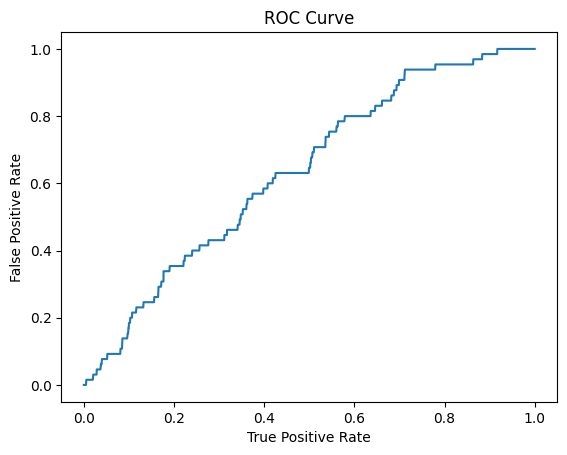

Training set areaUnderROC: 0.634137425471606


In [93]:
# Imprimiendo la curva ROC del mejor modelo
import matplotlib.pyplot as plt
# Desactivar Arrow globalmente en Spark
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

# Alternativa para extraer datos de ROC sin toPandas()
print("Extrayendo curva ROC sin Arrow...")

trainingSummary = best_lr_stage.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

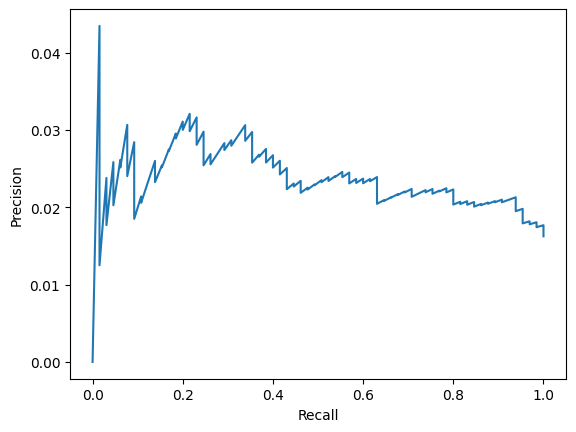

In [94]:
# Imprimiendo la curva entre Precision y Recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

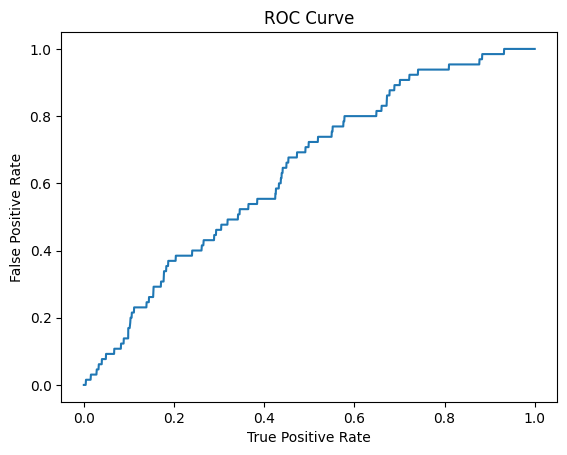

Training set areaUnderROC: 0.6376365946632785


In [95]:
# ROC del primero modelo sin hiperparametros
lr_stage = lr_model.stages[-1]
trainingSummary = lr_stage.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

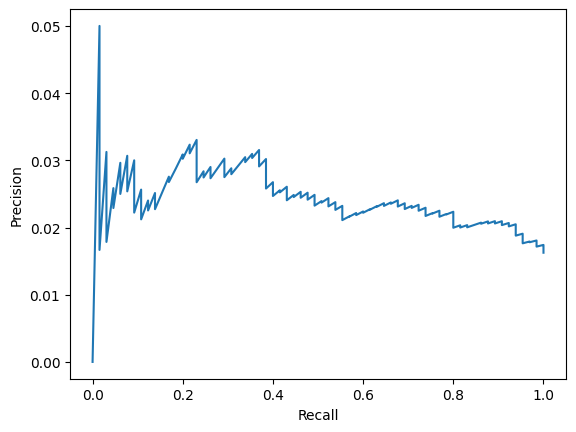

In [96]:
# Imprimiendo la curva entre Precision y Recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [97]:
# Guardar los modelos
base_path = "/Users/pauescalante/Documents/Maestria/Trimestre 7/BigData/big-data-act/Models/"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

lr_model_path = f"{base_path}/logistic_regression_model_{timestamp}"
try:
    lr_model.write().overwrite().save(lr_model_path)
    print(f"Modelo LR guardado en: {lr_model_path}")
except Exception as e:
    print(f"Error guardando LR: {e}")

Modelo LR guardado en: /Users/pauescalante/Documents/Maestria/Trimestre 7/BigData/big-data-act/Models//logistic_regression_model_20250608_225506


### **5. Análisis de resultados**



El presente análisis de resultados constituye la etapa final y más crítica del proceso de desarrollo de nuestro modelo de predicción de comportamiento de compra en e-commerce. Tras haber implementado un pipeline completo de machine learning que incluye muestreo estratificado representativo, optimización de hiperparámetros mediante Grid Search con validación cruzada, y evaluación exhaustiva utilizando métricas específicamente diseñadas para datasets desbalanceados, es fundamental examinar de manera rigurosa y objetiva los resultados obtenidos.

Este análisis trasciende la mera interpretación de métricas numéricas para adentrarse en una evaluación integral que considera tanto las fortalezas técnicas del modelo desarrollado como sus limitaciones prácticas en el contexto real de un negocio de comercio electrónico. Dado que trabajamos con un dataset severamente desbalanceado donde únicamente el 1.58% de las interacciones resultan en compras, el análisis debe contemplar no solo la precisión estadística del modelo, sino también su viabilidad comercial y capacidad para generar valor de negocio tangible.

A través de esta evaluación detallada, identificaremos las áreas donde el modelo demuestra competencia, las limitaciones críticas que comprometen su aplicabilidad práctica, y las oportunidades de mejora que podrían transformar el sistema en una herramienta verdaderamente efectiva para la toma de decisiones comerciales. Este enfoque holístico nos permitirá extraer lecciones valiosas tanto de los éxitos como de las deficiencias observadas, estableciendo las bases para futuras iteraciones y refinamientos del modelo predictivo.